In [2]:
import pandas as pd
from scipy import stats
import numpy as np
import itertools

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
file_list = []
for index in range(16):
    caminho_do_arquivo = f'../data/tripinfo_{index}.csv'
    file_list.append(caminho_do_arquivo)

n = len(file_list) # Número de sementes: 10 (Número de arquivos lido)
dfs = [pd.read_csv(file) for file in file_list]

df = pd.concat(dfs)
df.head(2)

,id,depart,departLane,departPos,departPosLat,departSpeed,departDelay,arrival,arrivalLane,arrivalPos,...,rerouteNo,devices,vType,speedFactor,vaporized,seed,ALGORITHM,CAR_FOLLOW_MODEL,VEHICLE_NUMBER,DELAY_TO_DISPATCH_EMERGENCY_VEHICLE
0,4,10.0,D3C3_0,5.1,0.0,0.0,0.4,41.0,C3B3_0,172.8,...,0,tripinfo_4,passenger_idm,1.03,NaN,99,proposto,Krauss,3000,20
1,9,22.0,A0B0_0,5.1,0.0,0.0,0.4,57.0,B0C0_0,172.8,...,0,tripinfo_9,passenger_idm,0.86,NaN,99,proposto,Krauss,3000,20


In [11]:
pd.set_option('display.max_columns', None)

In [12]:
df.head(2)

,id,depart,departLane,departPos,departPosLat,departSpeed,departDelay,arrival,arrivalLane,arrivalPos,arrivalPosLat,arrivalSpeed,duration,routeLength,waitingTime,waitingCount,stopTime,timeLoss,rerouteNo,devices,vType,speedFactor,vaporized,seed,ALGORITHM,CAR_FOLLOW_MODEL,VEHICLE_NUMBER,DELAY_TO_DISPATCH_EMERGENCY_VEHICLE
0,4,10.0,D3C3_0,5.1,0.0,0.0,0.4,41.0,C3B3_0,172.8,0.0,14.20,31.0,371.7,0.0,0,0.0,4.29,0,tripinfo_4,passenger_idm,1.03,NaN,99,proposto,Krauss,3000,20
1,9,22.0,A0B0_0,5.1,0.0,0.0,0.4,57.0,B0C0_0,172.8,0.0,11.58,35.0,371.7,0.0,0,0.0,3.52,0,tripinfo_9,passenger_idm,0.86,NaN,99,proposto,Krauss,3000,20


In [7]:
lista_index = ['ALGORITHM', 'CAR_FOLLOW_MODEL', 'VEHICLE_NUMBER','DELAY_TO_DISPATCH_EMERGENCY_VEHICLE']
var_resposta = list(set(df.columns) - set(lista_index+['id', 'depart', 'departLane', 'departPos', 'departPosLat',
                                                       'departSpeed', 'departDelay', 'arrival', 'arrivalLane', 'arrivalPos', 'arrivalPosLat',
                                                       'arrivalSpeed','devices','vaporized','vType',
                                                       ]))
var_resposta

['speedFactor',
 'routeLength',
 'stopTime',
 'rerouteNo',
 'seed',
 'timeLoss',
 'duration',
 'waitingCount',
 'waitingTime']

In [13]:
grouped = df.drop(columns=['id', 'depart', 'departLane', 'departPos', 'departPosLat',
                                                       'departSpeed', 'departDelay', 'arrival', 'arrivalLane', 'arrivalPos', 'arrivalPosLat',
                                                       'arrivalSpeed','devices','vaporized','vType',]).groupby(lista_index).agg(['mean','std']).reset_index()
#Cirando coluna ID para o gráfico de barra com intervalo de confiança
grouped['id'] = grouped[lista_index].apply(lambda x: '-'.join(x.astype(str)), axis=1)
grouped.sort_values(by=lista_index,ascending=[True, True,True,True], inplace=True)

grouped.head(2)

ALGORITHM CAR_FOLLOW_MODEL VEHICLE_NUMBER  \
                                              
0  proposto           Krauss           3000   

  DELAY_TO_DISPATCH_EMERGENCY_VEHICLE   duration            routeLength  \
                                            mean        std        mean   
0                                  20  153.89946  82.153344  918.906329   

              waitingTime            waitingCount           stopTime       \
          std        mean        std         mean       std     mean  std   
0  298.092721   52.801566  58.502528     2.364218  1.806952      0.0  0.0   

    timeLoss            rerouteNo      speedFactor            seed       \
        mean        std      mean  std        mean       std  mean  std   
0  79.450237  67.007242       0.0  0.0    1.002942  0.098292  99.0  0.0   

                        id  
                            
0  proposto-Krauss-3000-20

In [14]:
def calc_interval(grouped,var_resposta,n = 10,column_x = 'id', rotation = 0, z = stats.norm.ppf(0.975)):
    for var in var_resposta:
        #Calculo do erro médio para o intervalo de confiança
        grouped[(var, 'mean_error')] = z * (grouped[(var, 'std')] / np.sqrt(n))

In [15]:
calc_interval(grouped=grouped, var_resposta=var_resposta)

In [16]:
num_factors = len(lista_index)
factor_names = lista_index
factor_levels_real = {factor:list(grouped[factor].unique()) for factor in factor_names}
num_factors, factor_levels_real

(4,
 {'ALGORITHM': ['proposto'],
  'CAR_FOLLOW_MODEL': ['Krauss'],
  'VEHICLE_NUMBER': [3000],
  'DELAY_TO_DISPATCH_EMERGENCY_VEHICLE': [20]})

In [17]:
num_response_vars = len(var_resposta)
response_vars_names = var_resposta
num_response_vars, response_vars_names

(9,
 ['speedFactor',
  'routeLength',
  'stopTime',
  'rerouteNo',
  'seed',
  'timeLoss',
  'duration',
  'waitingCount',
  'waitingTime'])

In [92]:
# Calculating the total number of experiments
total_experiments = 2 ** num_factors
# total_experiments

16

In [94]:
# Preparing the DataFrame
level_combinations = list(itertools.product([-1, 1], repeat=num_factors))
experiment_design_df = pd.DataFrame(level_combinations, columns=factor_names)
experiment_design_df.insert(0, 'Exp', range(1, len(experiment_design_df) + 1))
# level_combinations, experiment_design_df

([(-1, -1, -1, -1),
  (-1, -1, -1, 1),
  (-1, -1, 1, -1),
  (-1, -1, 1, 1),
  (-1, 1, -1, -1),
  (-1, 1, -1, 1),
  (-1, 1, 1, -1),
  (-1, 1, 1, 1),
  (1, -1, -1, -1),
  (1, -1, -1, 1),
  (1, -1, 1, -1),
  (1, -1, 1, 1),
  (1, 1, -1, -1),
  (1, 1, -1, 1),
  (1, 1, 1, -1),
  (1, 1, 1, 1)],
     Exp  ALGORITHM  PROPORTION_DELAY_CALL_EMERGENCY_VEHICLE_TO_ACCIDENT  \
 0     1         -1                                                 -1     
 1     2         -1                                                 -1     
 2     3         -1                                                 -1     
 3     4         -1                                                 -1     
 4     5         -1                                                  1     
 5     6         -1                                                  1     
 6     7         -1                                                  1     
 7     8         -1                                                  1     
 8     9          1        

In [95]:
for var_name in response_vars_names:
    experiment_design_df[var_name] = grouped[var_name]['mean']
    experiment_design_df[var_name+'_err'] = grouped[var_name]['mean_error']
# experiment_design_df

,Exp,ALGORITHM,PROPORTION_DELAY_CALL_EMERGENCY_VEHICLE_TO_ACCIDENT,TRIPS_REPETITION_RATE,SIMULATION_END_TIME,fuel,fuel_err,waiting,waiting_err,electricity,...,noise,noise_err,speed,speed_err,CO,CO_err,HC,HC_err,CO2,CO2_err
0,1,-1,-1,-1,-1,956.984697,448.923844,6.607316,11.086146,0.0,...,59.700042,3.820111,5.145866,3.482521,106.933479,45.458826,0.715116,1.033674,3000.490077,1407.825946
1,2,-1,-1,-1,1,937.591309,447.477458,9.355359,22.947397,0.0,...,59.290474,3.708482,4.572177,3.415006,111.418288,45.291093,0.778711,1.167519,2939.681145,1403.318189
2,3,-1,-1,1,-1,948.492225,442.054032,9.857314,17.815339,0.0,...,59.505143,3.776554,4.877888,3.444196,110.005186,45.867893,0.819090,1.284055,2973.865218,1386.319300
3,4,-1,-1,1,1,943.177372,448.020914,10.072172,22.755126,0.0,...,59.335864,3.722567,4.629507,3.431178,111.322414,45.166578,0.755228,1.103172,2957.196656,1405.030196
4,5,-1,1,-1,-1,955.895701,450.024523,7.732694,15.212289,0.0,...,59.654445,3.815079,5.079909,3.475410,107.474516,45.285823,0.713340,1.022255,2997.069623,1411.257366
5,6,-1,1,-1,1,870.716998,297.850108,202.511931,177.569733,0.0,...,57.475622,2.713003,2.129899,2.704041,140.097580,36.506037,1.027032,1.434863,2729.839584,934.013515
6,7,-1,1,1,-1,949.627897,435.217882,12.615487,20.739302,0.0,...,59.489018,3.764145,4.864804,3.463140,110.501979,45.165068,0.783681,1.183259,2977.381582,1364.808700
7,8,-1,1,1,1,941.779433,430.330650,32.427069,57.794544,0.0,...,59.098010,3.627015,4.298866,3.405632,116.588232,44.197872,0.794807,1.141704,2952.788481,1349.537162
8,9,1,-1,-1,-1,959.547679,438.155371,10.222653,13.074958,0.0,...,59.500976,3.765724,4.851998,3.474452,111.005399,44.204192,0.680870,0.849142,3008.486713,1374.007787
9,10,1,-1,-1,1,947.245009,442.176058,12.416011,21.086026,0.0,...,59.270530,3.703018,4.540167,3.436725,113.118291,44.581470,0.710660,0.939596,2969.942279,1386.712286


In [96]:
# Generating interactions between factors
interaction_columns = []
for combo_length in range(2, num_factors + 1):
    for combo in itertools.combinations(factor_names, combo_length):
        interaction_name = ':'.join(combo)
        experiment_design_df[interaction_name] = np.prod(experiment_design_df[list(combo)], axis=1)
        interaction_columns.append(interaction_name)

In [99]:
# Adjusting real levels in the real experiment settings
experiment_settings_real_df = experiment_design_df.copy()
for factor_name in factor_names:
    experiment_settings_real_df[factor_name] = experiment_settings_real_df[factor_name].map({-1: factor_levels_real[factor_name][0], 1: factor_levels_real[factor_name][1]})

In [101]:
# Function to calculate the effects and SS
def calculate_effects_SS_dynamic(df, response_var_names):
    results = {}
    for response_var_name in response_var_names:
        n = len(df)
        response_values = df[response_var_name].values
        factor_columns = [col for col in df.columns if col not in ['Exp'] + response_var_names]
        effects = {}
        SS = {}

        for factor in factor_columns:
            factor_values = df[factor].values
            effect = np.sum(factor_values * response_values) / n
            effects[factor] = effect
            SS[factor] = n * effect ** 2

        SST = np.sum((response_values - np.mean(response_values)) ** 2)
        results[response_var_name] = (effects, SS, SST)
    return results

# Function to print formatted results
def print_formatted_results(results):
    for response_var_name, (effects, SS, SST) in results.items():
        print(f"\n{response_var_name} - Effects of Factors and Interactions:")
        for name, effect in effects.items():
            print(f"  {name}: {effect:.4f}")
        print(f"\n{response_var_name} - Sum of Squares (SS) for each Factor and Interaction:")
        for name, ss in SS.items():
            print(f"  {name}: {ss:.4f}")
        print(f"\n{response_var_name} - Total Sum of Squares (SST): {SST:.4f}")
        print(f"\n{response_var_name} - Percentage Influence of each Factor and Interaction:")
        for name, ss in SS.items():
            print(f"  {name}: {(ss / SST) * 100:.2f}%")

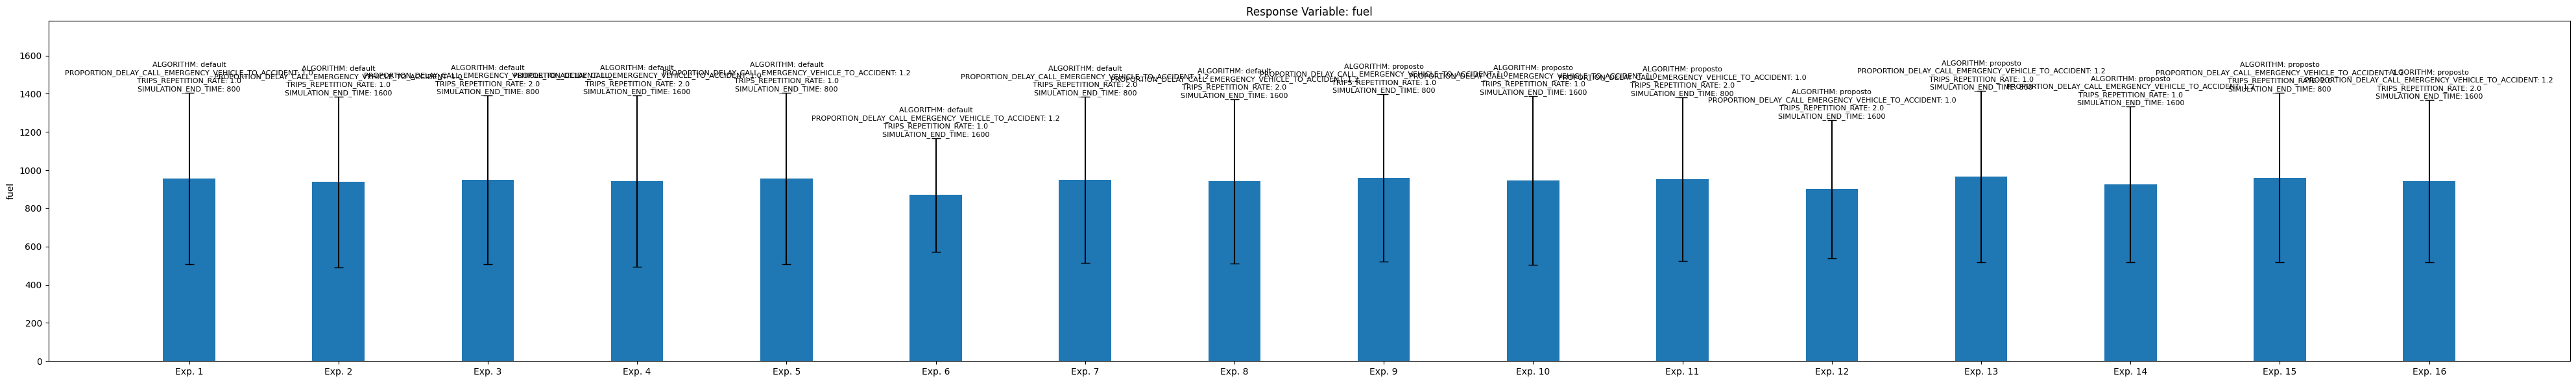

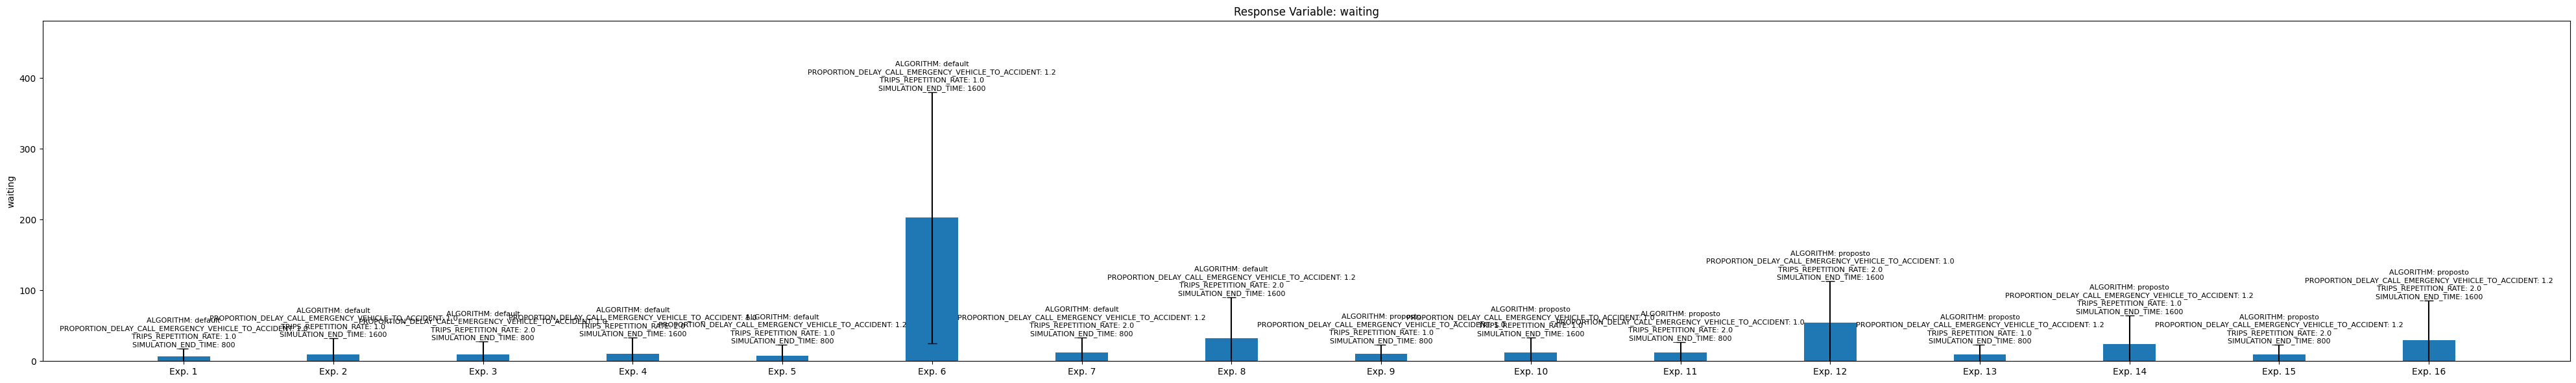

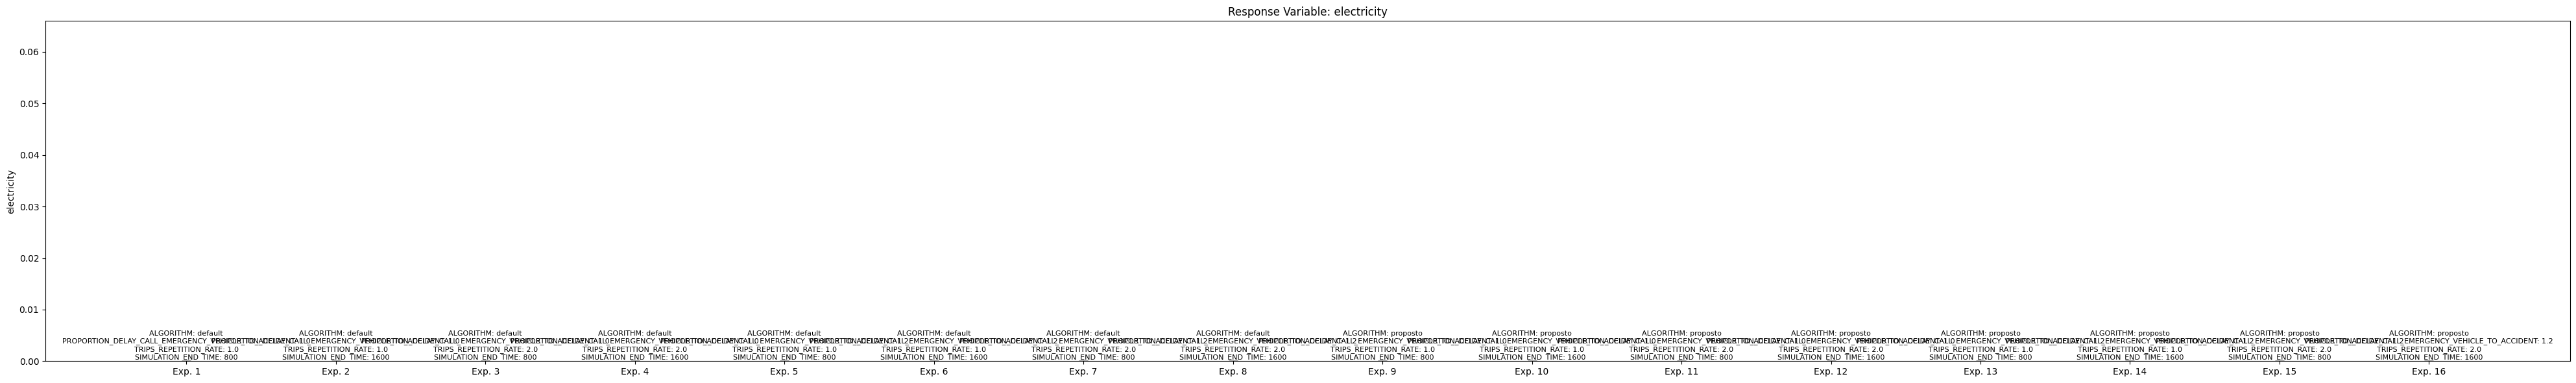

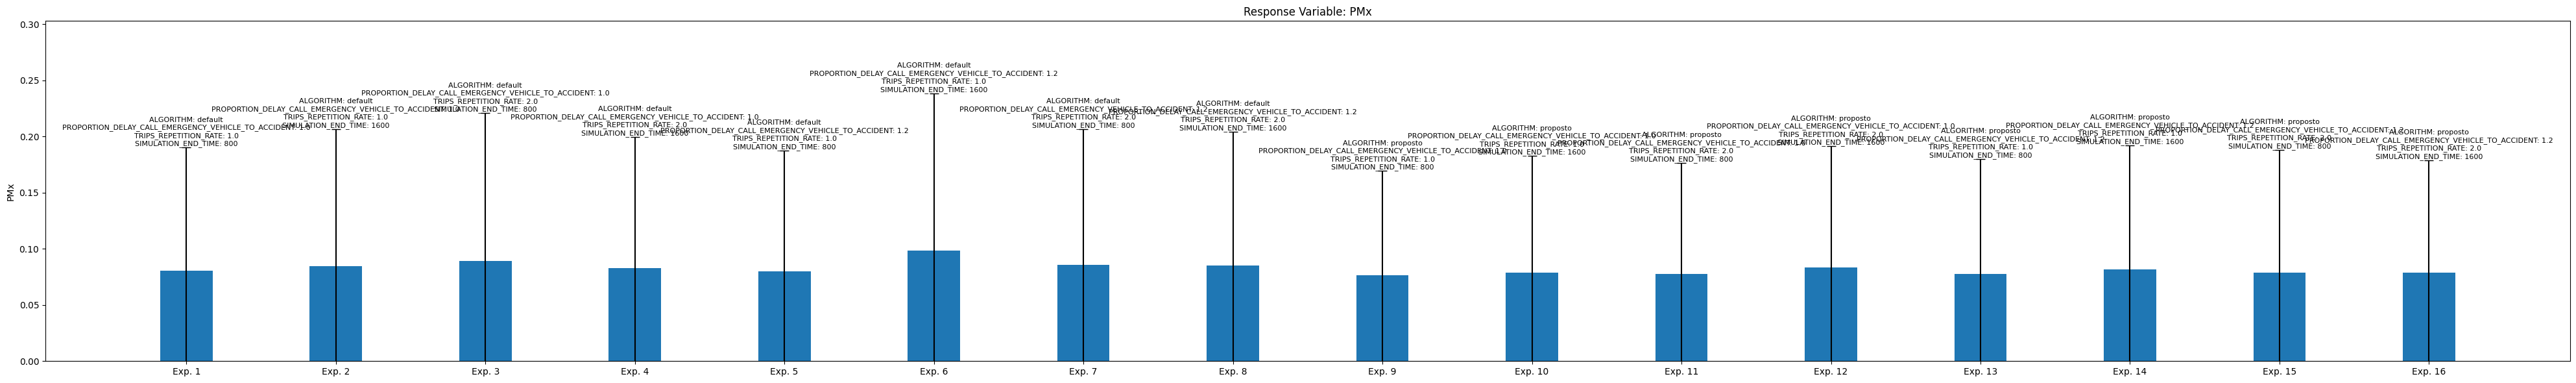

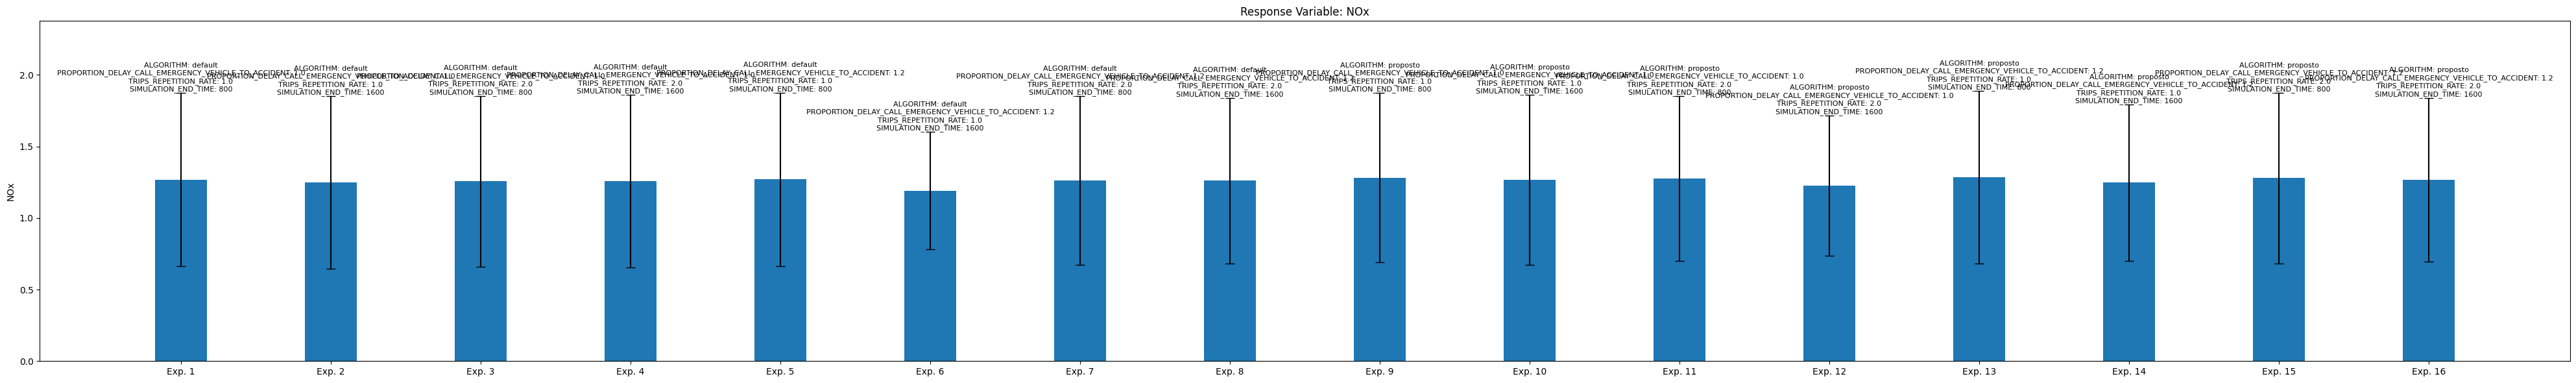

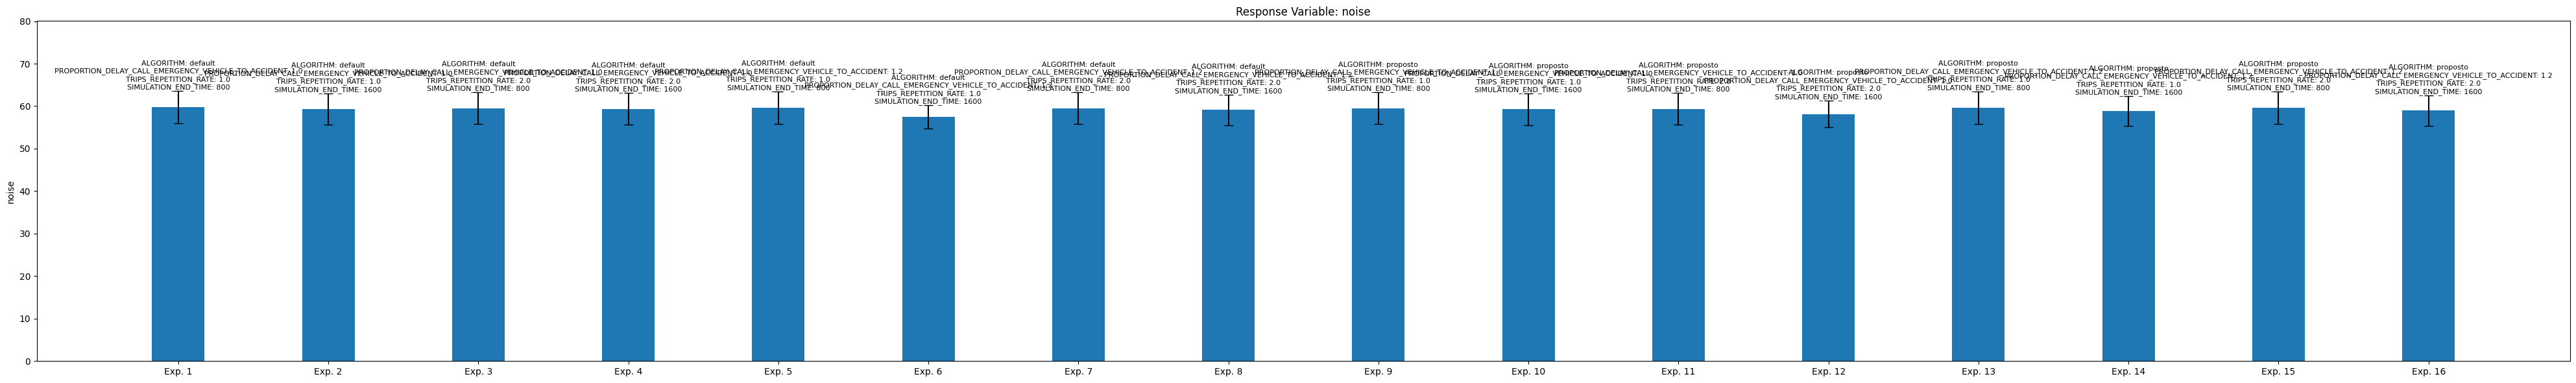

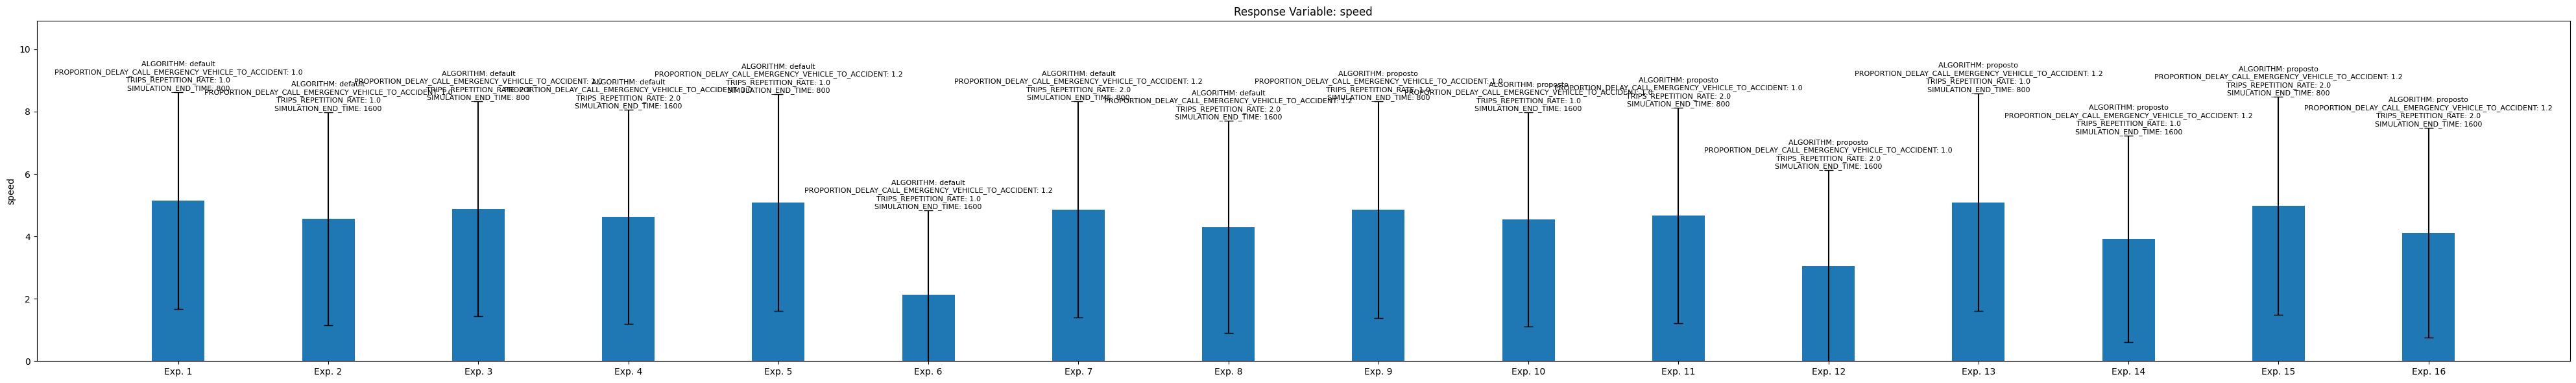

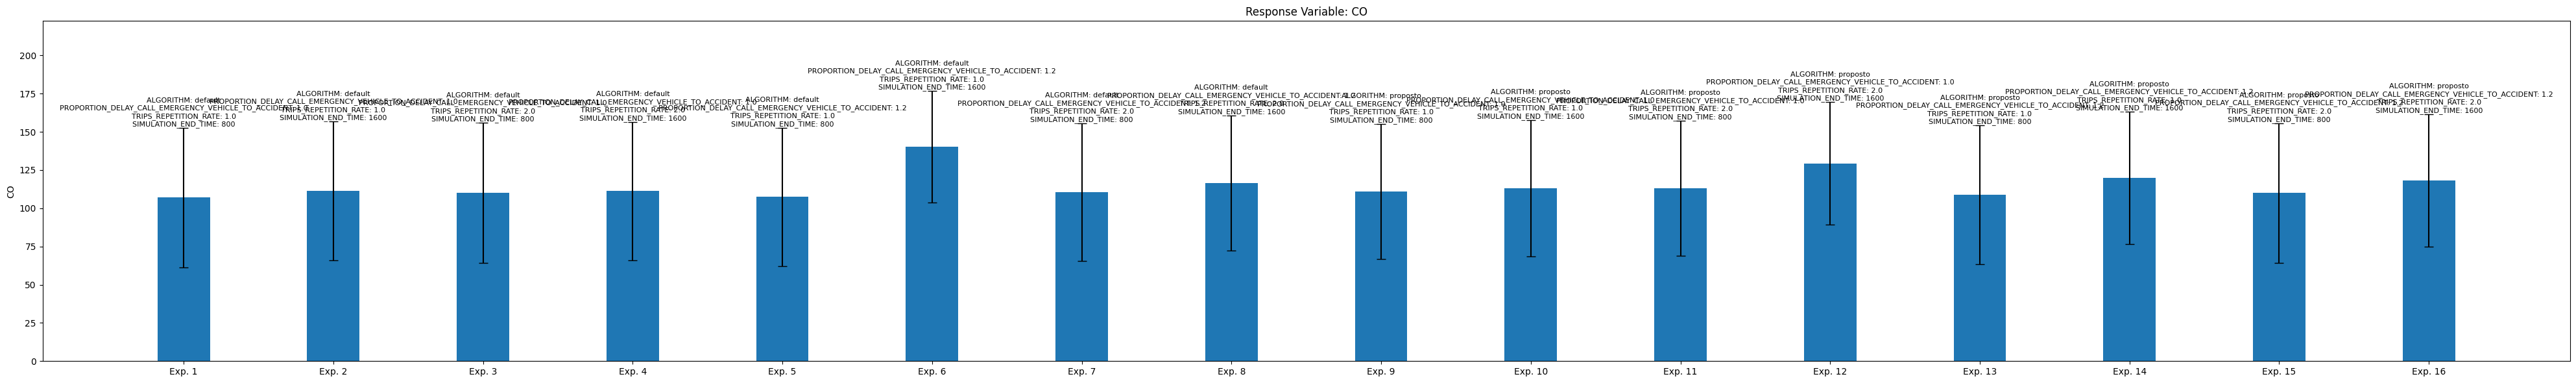

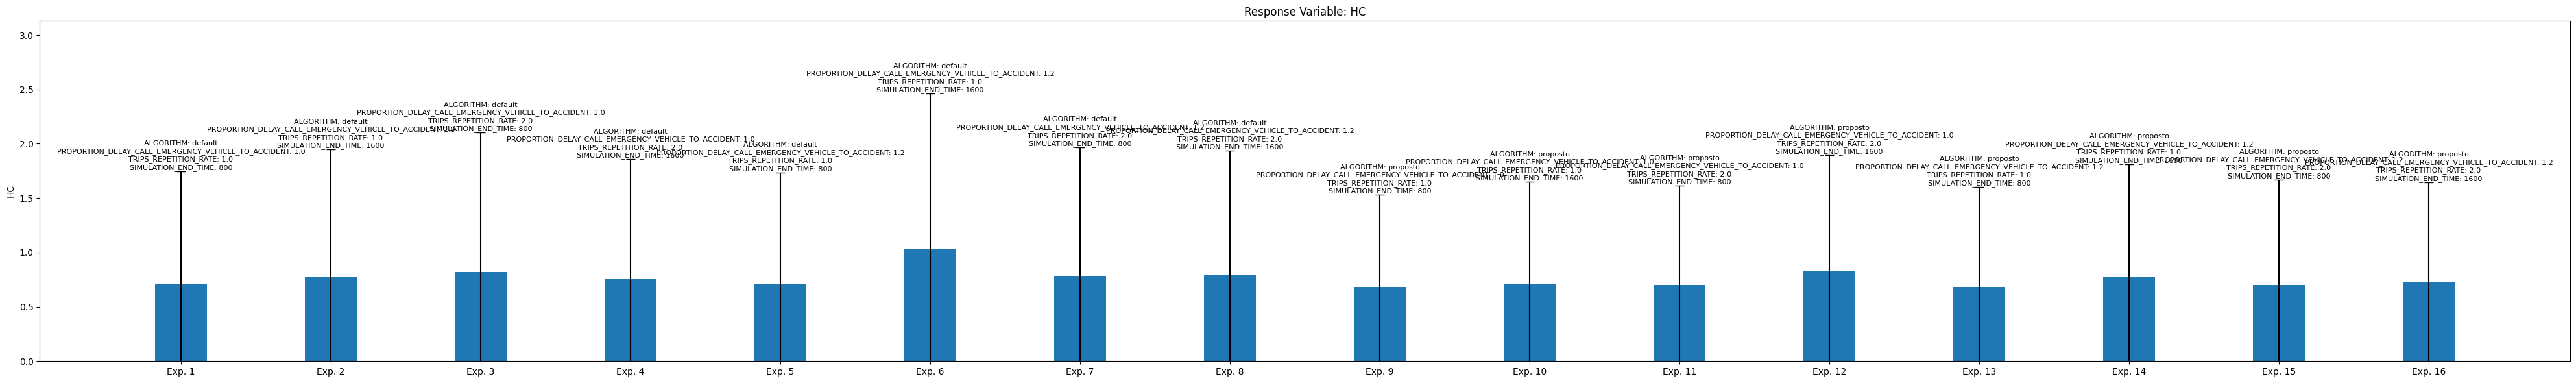

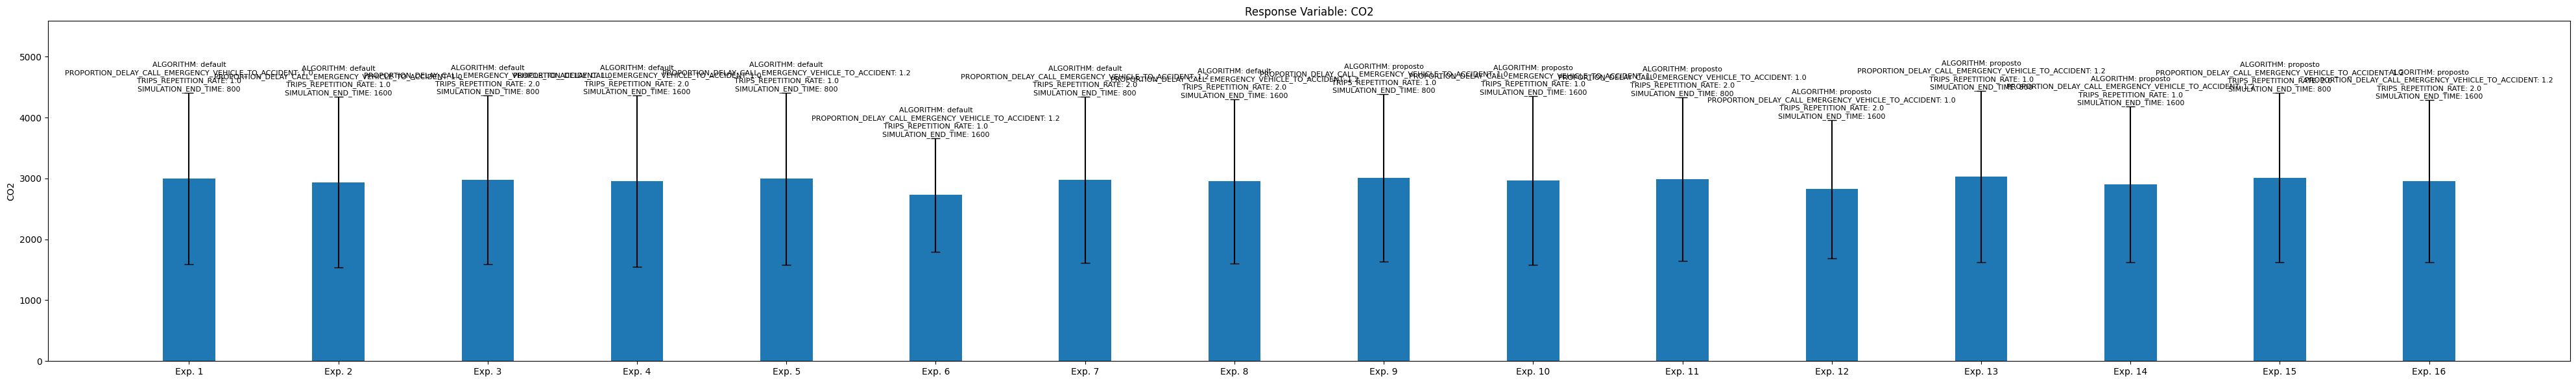

In [108]:
n_cols = 4
# Adjusting the bar width, if necessary
width = 0.35

for var_name in response_vars_names:
    # Increasing the chart height to accommodate labels
    plt.figure(figsize=(10 * n_cols, 6))  # Increasing the second value in figsize to increase the chart height
    
    n_experiments = len(experiment_settings_real_df)  # Number of experiments
    ind = np.arange(n_experiments)  # Indices for the experiments for bar positioning
    
    # Plotting the data from the real experiment settings
    bars = plt.bar(ind, experiment_settings_real_df[var_name],yerr=experiment_settings_real_df[var_name+"_err"],capsize=5,width= width, label='Experiments')
    # for i, (x_val, y_val, yerr_val) in enumerate(zip(grouped[column_x], grouped[(var, 'mean')], grouped[(var, 'mean_error')])):
    # plt.bar(x_val, y_val, yerr=yerr_val, color=colors[group_labels[i]], capsize=5)
    
    plt.title(f'Response Variable: {var_name}')  # Chart title
    plt.ylabel(var_name)  # Y-axis label
    
    # Generating labels for each bar based on factor combinations
    exp_labels = ['Exp. ' + str(exp) for exp in experiment_settings_real_df['Exp']]
    plt.xticks(ind, exp_labels)
    
    # Adding labels above bars to show factor combinations
    for bar, label in zip(bars, experiment_settings_real_df.to_dict('records')):
        height = bar.get_height()
        comb_label = '\n'.join([f"{k}: {v}" for k, v in label.items() if k in factor_names])
        height_err_plus = label[var_name+"_err"]
        plt.text(bar.get_x() + bar.get_width() / 2, height+height_err_plus, comb_label, ha='center', va='bottom', rotation=0, fontsize=8)
    
    # Adjusting the Y-axis limits to ensure labels fit without being cut off
    plt.ylim(0, plt.ylim()[1] * 1.2)  # Increases the upper limit of the Y-axis by 20%

    plt.tight_layout()
    plt.savefig('../plot/Experiment/{}.pdf'.format(var_name), format='pdf')
    plt.show()
